# Question revision chain

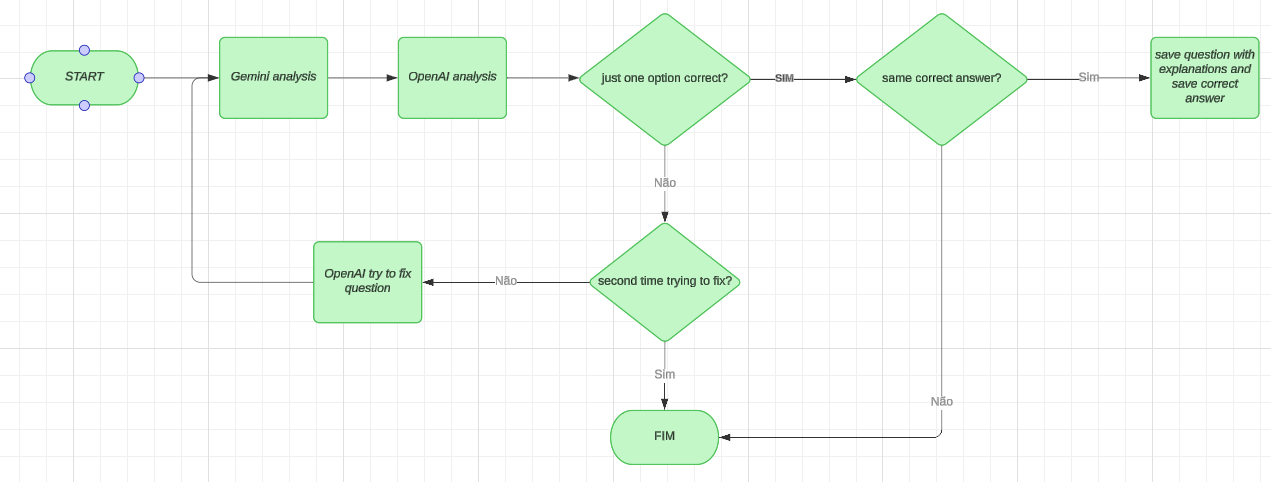

https://lucid.app/lucidchart/005f29d3-0274-4658-b470-e7e1cb8bc592/edit?viewport_loc=-283%2C-123%2C3415%2C1146%2C0_0&invitationId=inv_1b9160ba-6dae-4c95-b952-a272a699ca8e

In [1]:
from dotenv import load_dotenv
import json_repair
import json
import os
import pandas as pd
import time

from pydantic import BaseModel, Field
from typing import Literal

from langgraph.graph import END, START, StateGraph, MessagesState
from typing_extensions import TypedDict
# from typing import Annotated
from IPython.display import Image, display


from supabase import create_client, Client

import os
from dotenv import load_dotenv
load_dotenv()  # take environment variables from .env.

True

In [2]:
url: str = os.environ.get("SUPABASE_URL")
key: str = os.environ.get("SUPABASE_KEY")
supabase: Client = create_client(url, key)

In [3]:
df = pd.read_csv("questions.csv")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 953 entries, 0 to 952
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   id                 953 non-null    int64 
 1   created_at         953 non-null    object
 2   subject_matter     953 non-null    object
 3   topic_description  953 non-null    object
 4   level              953 non-null    object
 5   question           953 non-null    object
 6   type               953 non-null    object
 7   answer_correct     953 non-null    object
 8   explanation        953 non-null    object
 9   answer_a           953 non-null    object
 10  answer_b           953 non-null    object
 11  answer_c           953 non-null    object
 12  answer_d           953 non-null    object
dtypes: int64(1), object(12)
memory usage: 96.9+ KB


In [4]:
question = df.iloc[0]
question

id                                                                  11
created_at                               2024-09-22 12:31:43.546285+00
subject_matter                                             Probability
topic_description                       Understanding Confusion Matrix
level                                                     1 - Remember
question             Which term represents correctly classified pos...
type                                                  multiple_options
answer_correct                                                       a
explanation          True Positives (TP) represent the number of ca...
answer_a                                                True Positives
answer_b                                               False Positives
answer_c                                               False Negatives
answer_d                                                True Negatives
Name: 0, dtype: object

In [5]:
question["question"]

'Which term represents correctly classified positive cases?'

In [6]:
question = question.to_dict()
question

{'id': 11,
 'created_at': '2024-09-22 12:31:43.546285+00',
 'subject_matter': 'Probability',
 'topic_description': 'Understanding Confusion Matrix',
 'level': '1 - Remember',
 'question': 'Which term represents correctly classified positive cases?',
 'type': 'multiple_options',
 'answer_correct': 'a',
 'explanation': 'True Positives (TP) represent the number of cases that were correctly predicted as positive. False Positives (FP) are incorrectly predicted positive cases, True Negatives (TN) are correctly predicted negative cases, and False Negatives (FN) are incorrectly predicted negative cases.',
 'answer_a': 'True Positives',
 'answer_b': 'False Positives',
 'answer_c': 'False Negatives',
 'answer_d': 'True Negatives'}

## Gemini

In [7]:
import google.generativeai as genai
from google.ai.generativelanguage_v1beta.types import content

key_gemini = os.environ["GOOGLE_API_KEY"]

genai.configure(api_key=key_gemini)

/workspaces/quiz_interview/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [8]:
schema = content.Schema(
    type=content.Type.OBJECT,
    properties={
        "option_a_explanation": content.Schema(
            type=content.Type.STRING,
            description="Detailed explanation of why the option 'a' is correct or not.",
        ),
        "option_b_explanation": content.Schema(
            type=content.Type.STRING,
            description="Detailed explanation of why the option 'b' is correct or not.",
        ),
        "option_c_explanation": content.Schema(
            type=content.Type.STRING,
            description="Detailed explanation of why the option 'c' is correct or not.",
        ),
        "option_d_explanation": content.Schema(
            type=content.Type.STRING,
            description="Detailed explanation of why the option 'd' is correct or not.",
        ),
        "just_one_option_correct": content.Schema(
            type=content.Type.BOOLEAN,
            description="If there is just one option correct.",
        ),
        "correct_answer": content.Schema(
            type=content.Type.STRING,
            description="The correct option. It could be 'a', 'b', 'c', 'd'.",
        ),
    },
    required=[
        "option_a_explanation",
        "option_b_explanation",
        "option_c_explanation",
        "option_d_explanation",
        "just_one_option_correct",
        "correct_answer",
    ]
)

In [9]:
# Create the model
generation_config = {
    "temperature": 0.5,
    "top_p": 0.95,
    # "top_k": 64,
    # "max_output_tokens": 8192,
    "response_schema": schema,
    "response_mime_type": "application/json",
}
    

llm_gemini = genai.GenerativeModel(
    # model_name="gemini-1.5-flash",
    model_name="gemini-1.5-flash-exp-0827",
    # model_name="gemini-1.5-pro-exp-0827",
    generation_config=generation_config,
    # safety_settings = Adjust safety settings
    # See https://ai.google.dev/gemini-api/docs/safety-settings
)

In [10]:
prompt_revision = (
    "# BACKGROUND INFORMATION OF YOUR ROLE:\n"
    "You are an expert in machine learning.\n"
    "You are verifying if a question from a bank of question is ok to be used in a job interview.\n"
    "your task is to analyse the provided question to verify if there is some problem.\n"
    "You shoud verify if there is just one option correct or if there is more than one.\n"
    "The question could be perfect fine, so you could say it too.\n"
    "Also, you should give a detailed explanation for your answer.\n"
    "# QUESTION\n\n"
    "{question}\n\n"
    "# Option a\n"
    "{option_a}\n\n"
    "# Option b\n"
    "{option_b}\n\n"
    "# Option c\n"
    "{option_c}\n\n"
    "# Option d\n"
    "{option_d}\n\n"
)

## OpenAI

In [11]:
from openai import OpenAI

client_openai = OpenAI()

In [12]:
class ExplanationSchema(BaseModel):
    option_a_explanation: str = Field(..., description="Detailed explanation of why the option 'a' is correct or not.")
    option_b_explanation: str = Field(..., description="Detailed explanation of why the option 'b' is correct or not.")
    option_c_explanation: str = Field(..., description="Detailed explanation of why the option 'c' is correct or not.")
    option_d_explanation: str = Field(..., description="Detailed explanation of why the option 'd' is correct or not.")
    just_one_option_correct: bool = Field(..., description="If there is just one option correct.")
    correct_answer: Literal['a', 'b', 'c', 'd'] = Field(..., description="The correct option. It could be 'a', 'b', 'c', or 'd'.")


### Try to fix question

In [13]:
prompt_fix_question = (
    "# BACKGROUND INFORMATION OF YOUR ROLE:\n"
    "You are an expert in machine learning.\n"
    "You working (with some other professionals) verifying if a question from a bank of question is ok to be used in a job interview.\n"
    "The question has already been analized by other professionals. Their analysis is below.\n"
    "It was already pointed that this question could have more than one option as correct, but it shouldn't. It should have just one correct option.\n"
    "# YOUR TASK\n"
    "your task is to fix the questions and/or the options in a way that it mantain the overall ideia for this question, but it should have after your correction, just one option as correct.\n"
    "Also, you should give a detailed explanation for your answer.\n\n"
    "# ORIGINAL QUESTION\n\n"
    "{question}\n\n"
    "# Option a\n"
    "{option_a}\n\n"
    "# Option b\n"
    "{option_b}\n\n"
    "# Option c\n"
    "{option_c}\n\n"
    "# Option d\n"
    "{option_d}\n\n"

    "# PROFESSIONAL ANALYSIS\n"
    "option_a_explanation\n"
    "{option_a_explanation}\n"
    "option_b_explanation\n"
    "{option_b_explanation}\n"
    "option_c_explanation\n"
    "{option_c_explanation}\n"
    "option_d_explanation\n"
    "{option_d_explanation}\n"
    
)

In [14]:
class QuestionSchema(BaseModel):
    question: str = Field(..., description="The actual question text (fixed if necessary). It should be a question of type MULTIPLE OPTIONS. In this field you should put only the caput of the question, leaving the options to put in another field.")
    
    answer_a: str = Field(..., description="Option 'a' of answer for the current question (fixed if necessary).")
    answer_b: str = Field(..., description="Option 'b' of answer for the current question. (fixed if necessary)")
    answer_c: str = Field(..., description="Option 'c' of answer for the current question. (fixed if necessary)")
    answer_d: str = Field(..., description="Option 'd' of answer for the current question. (fixed if necessary)")

    option_a_explanation: str = Field(..., description="Detailed explanation of why the option 'a' is correct or not.")
    option_b_explanation: str = Field(..., description="Detailed explanation of why the option 'b' is correct or not.")
    option_c_explanation: str = Field(..., description="Detailed explanation of why the option 'c' is correct or not.")
    option_d_explanation: str = Field(..., description="Detailed explanation of why the option 'd' is correct or not.")
    
    correct_answer: Literal['a', 'b', 'c', 'd'] = Field(..., description="The correct option. It could be 'a', 'b', 'c', or 'd'.")
    
    just_one_option_correct: bool = Field(..., description="If there is just one option correct.")

    correction_explanation: str = Field(..., description="Describe the correction you did in this question.")

# Graph

In [15]:
class State(TypedDict):
    question: dict = None
    
    analysis_gemini: dict = None
    analysis_openai: dict = None

    already_tried_to_fix: bool = False

    question_old: dict = None

In [16]:
def chain_analysis_gemini(state: State):
    print("--------- chain_analysis_gemini ---------")

    question = state["question"]
    
    prompt_revision_formatted = prompt_revision.format(
        question=question["question"],
        option_a=question["answer_a"],
        option_b=question["answer_b"],
        option_c=question["answer_c"],
        option_d=question["answer_d"],        
    )

    for i in range(3):
        print(f"Try: {i}")
        try:
            response = llm_gemini.generate_content(prompt_revision_formatted)
            analysis_gemini = json_repair.loads(response.text)
            break
        except:
            wait_time = 70
            print(f"Sleeping {wait_time}")
            time.sleep(wait_time)
    
    return { "analysis_gemini": analysis_gemini }


In [17]:
def chain_analysis_openai(state: State):
    print("--------- chain_analysis_openai ---------")
    
    question = state["question"]

    prompt_revision_formatted = prompt_revision.format(
        question=question["question"],
        option_a=question["answer_a"],
        option_b=question["answer_b"],
        option_c=question["answer_c"],
        option_d=question["answer_d"],
    )

    for i in range(3):
        print(f"Try: {i}")
        try:
            completion = client_openai.beta.chat.completions.parse(
                model="gpt-4o-mini",
                messages=[
                    {"role": "system", "content": prompt_revision_formatted},
                    # {"role": "user", "content": "hello"}
                ],
                response_format=ExplanationSchema,
            )

            analysis_openai = json_repair.loads( completion.choices[0].message.parsed.model_dump_json() )
            
            break
        except:
            wait_time = 70
            print(f"Sleeping {wait_time}")
            time.sleep(wait_time)
    
    return { "analysis_openai": analysis_openai }

In [18]:
def chain_try_fix_question(state: State):
    print("--------- chain_try_fix_question ---------")
    
    question = state["question"]
    analysis_gemini = state["analysis_gemini"]

    prompt_fix_question_formatted = prompt_fix_question.format(
        question=question["question"],
        option_a=question["answer_a"],
        option_b=question["answer_b"],
        option_c=question["answer_c"],
        option_d=question["answer_d"],

        option_a_explanation=analysis_gemini["option_a_explanation"],
        option_b_explanation=analysis_gemini["option_b_explanation"],
        option_c_explanation=analysis_gemini["option_c_explanation"],
        option_d_explanation=analysis_gemini["option_d_explanation"],
    )

    for i in range(3):
        print(f"Try: {i}")
        try:
            completion = client_openai.beta.chat.completions.parse(
                model="gpt-4o-mini",
                messages=[
                    {"role": "system", "content": prompt_fix_question_formatted},
                    # {"role": "user", "content": "hello"}
                ],
                response_format=QuestionSchema,
            )

            question_openai_fixed = json_repair.loads(
                completion.choices[0].message.parsed.model_dump_json()
            )
            
            break
        except:
            wait_time = 70
            print(f"Sleeping {wait_time}")
            time.sleep(wait_time)

    question_openai_fixed["subject_matter"] = question["subject_matter"]
    question_openai_fixed["topic_description"] = question["topic_description"]
    question_openai_fixed["level"] = question["level"]
    question_openai_fixed["type"] = question["type"]

    print("question_openai_fixed")
    print(question_openai_fixed)

    return {
        "question": question_openai_fixed,
        "question_old": question,
        "already_tried_to_fix": True
    }

In [25]:
def save_question(state: State):
    print("--------- save_question ---------")
    
    question = state["question"]
    analysis_gemini = state["analysis_gemini"]
    analysis_openai = state["analysis_openai"]


    if analysis_openai["correct_answer"] == analysis_gemini["correct_answer"]:
        print("OpenAI and Gemini agree.")
        
        row = {
                "subject_matter": question["subject_matter"] + "_fixed",
                "topic_description": question["topic_description"],
                "level": question["level"],
                "question": question["question"],
                "type": question["type"],
                "answer_correct": question["answer_correct"],
                "answer_a": question["answer_a"],
                "answer_b": question["answer_b"],
                "answer_c": question["answer_c"],
                "answer_d": question["answer_d"],
                "option_a_explanation": analysis_openai["option_a_explanation"],
                "option_b_explanation": analysis_openai["option_b_explanation"],
                "option_c_explanation": analysis_openai["option_c_explanation"],
                "option_d_explanation": analysis_openai["option_d_explanation"],
            }
        
        # response = supabase.table('question').insert(row).execute()
        
        print("row")
        print(row)
        
        print("END!!")
    else:
        print("Any of the LLMs agree, discart question.")
        return END
    



In [26]:
def verify_ok(state: State):
    print("--------- verify_ok ---------")
    
    analysis_gemini = state["analysis_gemini"]
    analysis_openai = state["analysis_openai"]
    already_tried_to_fix = state["already_tried_to_fix"]

    print("analysis_gemini")
    print(analysis_gemini)
    print("-------------------")
    print("analysis_openai")
    print(analysis_openai)
    print("-------------------")

    if analysis_gemini["just_one_option_correct"] and analysis_openai['just_one_option_correct']:
        print("Both question with just one option True!")
        if analysis_gemini["correct_answer"] == analysis_openai['correct_answer']:
            print("Both question with same correct answer!")
            return "save_question"
        else:
            print("Question with different correct answer!")
            return "chain_analysis_openai"
    elif already_tried_to_fix:
        print("Question more than one option True!")
        print("It tryed to fix the question already, so discart this question.")
        return END
    else:
        print("Question more than one option True!")
        # TODO: i could try open ai analysis before try to fix
        print("Try to fix the question!")
        return "chain_try_fix_question"

In [27]:
graph_builder = StateGraph(State)

graph_builder.add_node("chain_analysis_gemini", chain_analysis_gemini)
graph_builder.add_node("chain_analysis_openai", chain_analysis_openai)
graph_builder.add_node("chain_try_fix_question", chain_try_fix_question)
graph_builder.add_node("save_question", save_question)

graph_builder.add_edge(START, "chain_analysis_gemini")
graph_builder.add_edge("chain_analysis_gemini", "chain_analysis_openai")
graph_builder.add_conditional_edges(
    # First, we define the start node. We use `agent`.
    # This means these are the edges taken after the `agent` node is called.
    "chain_analysis_openai",
    # Next, we pass in the function that will determine which node is called next.
    verify_ok,
)

graph_builder.add_edge("chain_try_fix_question", "chain_analysis_gemini")
graph_builder.add_edge("save_question", END)

In [28]:
from langgraph.checkpoint.memory import MemorySaver
checkpointer = MemorySaver()

app = graph_builder.compile(checkpointer=checkpointer)

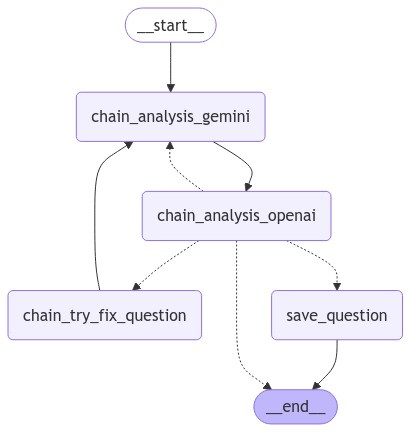

In [29]:
display(Image(app.get_graph().draw_mermaid_png()))

In [30]:
response = app.invoke(
    {
        "already_tried_to_fix": False,
        "question": question
    },
    config={"configurable": {"thread_id": 42}}
)

response

--------- chain_analysis_gemini ---------
Try: 0
--------- chain_analysis_openai ---------
Try: 0
--------- verify_ok ---------
analysis_gemini
{'correct_answer': 'a', 'just_one_option_correct': True, 'option_a_explanation': "True Positives (TP) represent the cases where the model correctly predicted the positive class. This is the desired outcome when evaluating a model's performance, particularly in binary classification problems.", 'option_b_explanation': 'False Positives (FP) represent cases where the model incorrectly predicted the positive class when the actual class was negative. This is also known as a Type I error.', 'option_c_explanation': 'False Negatives (FN) represent cases where the model incorrectly predicted the negative class when the actual class was positive. This is also known as a Type II error.', 'option_d_explanation': "True Negatives (TN) represent cases where the model correctly predicted the negative class. While important for evaluating overall performance, t

{'question': {'id': 11,
  'created_at': '2024-09-22 12:31:43.546285+00',
  'subject_matter': 'Probability',
  'topic_description': 'Understanding Confusion Matrix',
  'level': '1 - Remember',
  'question': 'Which term represents correctly classified positive cases?',
  'type': 'multiple_options',
  'answer_correct': 'a',
  'explanation': 'True Positives (TP) represent the number of cases that were correctly predicted as positive. False Positives (FP) are incorrectly predicted positive cases, True Negatives (TN) are correctly predicted negative cases, and False Negatives (FN) are incorrectly predicted negative cases.',
  'answer_a': 'True Positives',
  'answer_b': 'False Positives',
  'answer_c': 'False Negatives',
  'answer_d': 'True Negatives'},
 'analysis_gemini': {'correct_answer': 'a',
  'just_one_option_correct': True,
  'option_a_explanation': "True Positives (TP) represent the cases where the model correctly predicted the positive class. This is the desired outcome when evaluati

In [31]:
question["subject_matter"]

'Probability'